In [1]:
import numpy as np
import os
from pandas import DataFrame
from skimage import transform, img_as_bool, img_as_int, img_as_ubyte, img_as_float32
import skimage.io as io
from skimage.measure import label, marching_cubes_lewiner, mesh_surface_area, regionprops
import zipfile
#import cv2

def Trim_Individual_Stack(large_stack, small_stack):
    print("***trimming stack***")
    dims = np.array(binary_stack.shape, dtype='float') / np.array(raw_pred_stack.shape, dtype='float')
    if np.all(dims <= 2):
        return large_stack
    else:
        if dims[1] > 2:
            if (large_stack.shape[1]-1)/2 == small_stack.shape[1]:
                large_stack = np.delete(large_stack, large_stack.shape[1]-1, axis=1)
            else:
                if (large_stack.shape[1]-2)/2 == small_stack.shape[1]:
                    large_stack = np.delete(large_stack, np.arange(large_stack.shape[1]-2, large_stack.shape[1]), axis=1)
        if dims[2] > 2:
            if (large_stack.shape[2]-1)/2 == small_stack.shape[2]:
                large_stack = np.delete(large_stack, large_stack.shape[2]-1, axis=2)
            else:
                if (large_stack.shape[2]-2)/2 == small_stack.shape[2]:
                    large_stack = np.delete(large_stack, np.arange(large_stack.shape[2]-2, large_stack.shape[2]), axis=2)
        return large_stack

In [2]:
#Pixel dimmension
px_edge = 0.1625 #µm
vx_volume = px_edge**3

#Define de values of the different tissues
epid_value = 69
bg_value = 177
spongy_value = 0
palisade_value = 0
if spongy_value == palisade_value:
    mesophyll_value = spongy_value
else:
    mesophyll_value = [spongy_value, palisade_value]
ias_value = 255
vein_value = 147


In [3]:
#Load segmented image
base_folder_name = '/run/media/gtrancourt/DATADRIVE1/guillaume/_WORK/Vitis/Vitis_greenhouse_shading/microCT/_ML_DONE/'
sample_name = 'S_I_2_Strip4_'
folder_name = 'MLresults/'
binary_filename = sample_name + 'BINARY-8bit.tif'
raw_ML_prediction_name = 'fullstack_prediction.tif'

filepath = base_folder_name + sample_name + '/'

In [4]:
if os.path.isfile(filepath + sample_name + 'RESULTS.txt'):
    print('This file has already been processed!')
    assert False

This file has already been processed!


AssertionError: 

[  0  64 128 191 255]


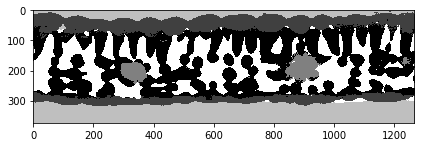

In [5]:
# Load the ML segmented stack
raw_pred_stack = io.imread(filepath + folder_name + raw_ML_prediction_name)
print(np.unique(raw_pred_stack[100]))
io.imshow(raw_pred_stack[100])

In [6]:
# Sometimes, the output values are different than what is written above.
# This is a way to assign values. But you have to double-check that the other is right.

#mesophyll_value, bg_value, epid_value, vein_value, ias_value = np.split(np.unique(raw_pred_stack[100]), len(np.unique(raw_pred_stack[100])))

#Define de values of the different tissues
epid_value = 64
bg_value = 191
mesophyll_value = 0
ias_value = 255
vein_value = 128

/home/gtrancourt/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


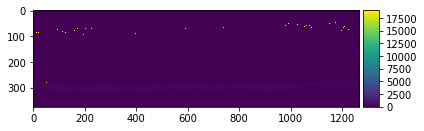

In [7]:
###################
## EPIDERMIS
###################

# Label all of the epidermis regions 
unique_epidermis_volumes = label(raw_pred_stack == epid_value, connectivity=1)
props_of_unique_epidermis = regionprops(unique_epidermis_volumes)

io.imshow(unique_epidermis_volumes[100])

The two largest values below should be in the same order of magnitude
[5.28600000e+03 5.90900000e+03 7.72300070e+07 1.05951612e+08]
The center of the epidermis should be more or less the same on the 1st and 3rd columns
[[1913.76768823   20.861521     88.21415059]
 [1562.1521408   263.92841428 1160.36419022]
 [1037.51938725  311.02541134  615.52176946]
 [ 921.14584318   62.03463843  629.19045172]]


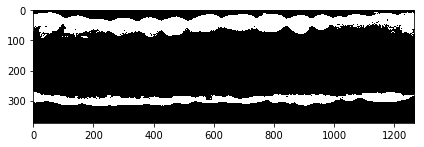

In [8]:
# Find the size and properties of the epidermis regions
epidermis_area = np.zeros(len(props_of_unique_epidermis))
epidermis_label = np.zeros(len(props_of_unique_epidermis))
epidermis_centroid = np.zeros([len(props_of_unique_epidermis),3])
for regions in np.arange(len(props_of_unique_epidermis)):
    epidermis_area[regions] = props_of_unique_epidermis[regions].area
    epidermis_label[regions] = props_of_unique_epidermis[regions].label
    epidermis_centroid[regions] = props_of_unique_epidermis[regions].centroid

# Find the two largest epidermis
ordered_epidermis = np.argsort(epidermis_area)
print('The two largest values below should be in the same order of magnitude')
print(epidermis_area[ordered_epidermis[-4:]])
print('The center of the epidermis should be more or less the same on the 1st and 3rd columns')
print(epidermis_centroid[ordered_epidermis[-4:]])

two_largest_epidermis = (unique_epidermis_volumes == ordered_epidermis[-1]+1) | (unique_epidermis_volumes == ordered_epidermis[-2]+1)

#Check if it's correct
#io.imsave(filepath + folder_name + 'test_epidermis.tif', 
#          img_as_ubyte(two_largest_epidermis))
io.imshow(two_largest_epidermis[100])

In [9]:
# Get the values again: makes it cleaner
unique_epidermis_volumes = label(two_largest_epidermis, connectivity=1)
props_of_unique_epidermis = regionprops(unique_epidermis_volumes)
epidermis_area = np.zeros(len(props_of_unique_epidermis))
epidermis_label = np.zeros(len(props_of_unique_epidermis))
epidermis_centroid = np.zeros([len(props_of_unique_epidermis),3])
for regions in np.arange(len(props_of_unique_epidermis)):
    epidermis_area[regions] = props_of_unique_epidermis[regions].area
    epidermis_label[regions] = props_of_unique_epidermis[regions].label
    epidermis_centroid[regions] = props_of_unique_epidermis[regions].centroid

#io.imshow(unique_epidermis_volumes[100])

# Transform the array to 8-bit: no need for the extra precision as there are only 3 values
unique_epidermis_volumes = np.array(unique_epidermis_volumes, dtype='uint8')

# Find the fvalues of each epidermis: assumes adaxial epidermis is at the top of the image
adaxial_epidermis_value = unique_epidermis_volumes[100,:,100][(unique_epidermis_volumes[100,:,100] != 0).argmax()]
abaxial_epidermis_value = int(np.arange(start=1,stop=3)[np.arange(start=1,stop=3) != adaxial_epidermis_value])

# Compute volume
epidermis_adaxial_volume = epidermis_area[adaxial_epidermis_value - 1] * (px_edge * (px_edge*2)**2)
epidermis_abaxial_volume = epidermis_area[abaxial_epidermis_value - 1] * (px_edge * (px_edge*2)**2)

# Tichkness return a 2D array, i.e. the thcikness of each column
epidermis_abaxial_thickness = np.sum((unique_epidermis_volumes == abaxial_epidermis_value), axis=1) * (px_edge*2)
epidermis_adaxial_thickness = np.sum((unique_epidermis_volumes == adaxial_epidermis_value), axis=1) * (px_edge*2)


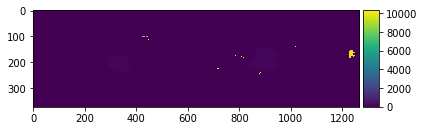

In [10]:
###################
## VEINS
###################

# Get the veins volumes
unique_vein_volumes = label(raw_pred_stack == vein_value, connectivity=1)
props_of_unique_veins = regionprops(unique_vein_volumes)

io.imshow(unique_vein_volumes[100])

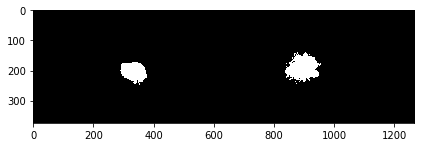

In [11]:
veins_area = np.zeros(len(props_of_unique_veins))
veins_label = np.zeros(len(props_of_unique_veins))
veins_centroid = np.zeros([len(props_of_unique_veins),3])
for regions in np.arange(len(props_of_unique_veins)):
    veins_area[regions] = props_of_unique_veins[regions].area
    veins_label[regions] = props_of_unique_veins[regions].label
    veins_centroid[regions] = props_of_unique_veins[regions].centroid

# Find the largest veins
ordered_veins = np.argsort(veins_area)
#veins_area[ordered_veins[-80:]]
#veins_area[ordered_veins[:1000]]
#veins_centroid[ordered_veins[-4:]]

#print(np.sum(veins_area <= 1000))

# I found that for my images, a threshold of 100000 (1e5) pixel^3 remove 
# the noise left by the segmentation method and kept only the argest veins.
# This should be adjusted depending on the species/images/maginification.
large_veins_ids = veins_label[veins_area > 100000]

largest_veins = np.in1d(unique_vein_volumes, large_veins_ids).reshape(raw_pred_stack.shape)

# Get the values again
vein_volume = np.sum(largest_veins) * (px_edge * (px_edge*2)**2)

#Check if it's correct
#io.imsave(base_folder_name + sample_name + '/' + folder_name + 'test_veins.tif', 
#          img_as_ubyte(largest_veins))
io.imshow(largest_veins[100])


In [12]:
###################
## AIRSPACE
###################

#########################################
## CREATE THE FULLSIZE SEGMENTED STACK ##
#########################################

# My segmenteation procedure used a reduced size stack, since my original 
# images are too big to be handled. I do want to use my original images for
# their quality and details, so I use the binary image and add on top of it
# the background, epidermis, and veins that have been segmented. That way, I 
# keep the detail I want at the airspace-cell interface, while still having a
# good background, epidermis, and vein segmentation to remove the tissues that
# are not need for some traits.

##############################
## LOADING THE BINARY STACK ##
## IN ORIGINAL SIZE         ##
##############################

# I've started compressing my files. The code below extracts the file,
# loads it into memory, and then deletes the file (it's still in memory).
# The commented code at the end loads the uncompressed image.

#Load the compressed binary stack in the original dimensions

binary_zip = zipfile.ZipFile(base_folder_name + sample_name + '/' + binary_filename + '.zip', 'r')
binary_zip.extractall(base_folder_name + sample_name + '/')
#binary_raw = binary_zip.open(sample_name + '/' + binary_filename)
binary_stack = img_as_bool(io.imread(base_folder_name + sample_name + '/' + sample_name + '/' + binary_filename))

os.remove(base_folder_name + sample_name + '/' + sample_name + '/' + binary_filename)
os.rmdir(base_folder_name + sample_name + '/' + sample_name)


/home/gtrancourt/anaconda2/lib/python2.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from uint8 to bool
  .format(dtypeobj_in, dtypeobj_out))


In [13]:
#Check and trim the binary stack if necessary
# This is to match the dimensions between all images
# Basically, it trims odds numbered dimension so to be able to divide/multiply them by 2.
binary_stack = Trim_Individual_Stack(binary_stack, raw_pred_stack)

# TO MANUALLY DELETE SOME SLICES
#binary_stack = np.delete(binary_stack, 910, axis=1)
#binary_stack = np.delete(binary_stack, 482, axis=0)

#binary_stack = np.delete(binary_stack, np.arange(0, 160*2), axis=2)

***trimming stack***


/home/gtrancourt/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/gtrancourt/anaconda2/lib/python2.7/site-packages/skimage/util/dtype.py:126: UserWarning: Possible sign loss when converting negative image of type float64 to positive image of type bool.
  .format(dtypeobj_in, dtypeobj_out))
/home/gtrancourt/anaconda2/lib/python2.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to bool
  .format(dtypeobj_in, dtypeobj_out))


### Validate the values in the stack ###
[  0  30  60 147 177 255]


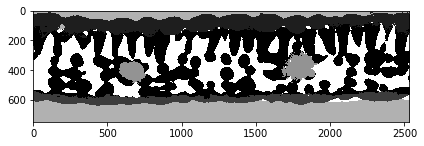

In [14]:
# This cell creates an empty array filled with the backgroud color (177), then
# adds all of the leaf to it. Looping over each slice (this is more memory 
# efficient than working on the whole stack), it takes the ML segmented image,
# resize the slice, and adds it to the empty array.
bg_value_new = 177
vein_value_new = 147
ias_value_new = 255

large_segmented_stack = np.full(shape=binary_stack.shape, fill_value=bg_value_new, dtype='uint8') # Assign an array filled with the background value 177.
for idx in np.arange(large_segmented_stack.shape[0]):
    # Creates a boolean 2D array of the veins (from the largest veins id'ed earlier)
    temp_veins = img_as_bool(transform.resize(largest_veins[idx],
                                              [binary_stack.shape[1], binary_stack.shape[2]], 
                                              anti_aliasing=False, order=0))    
    # Creates a 2D array with the epidermis being assinged values 30 or 60
    temp_epid = transform.resize(unique_epidermis_volumes[idx],
                                              [binary_stack.shape[1], binary_stack.shape[2]], 
                                              anti_aliasing=False, preserve_range=True, order=0) * 30
    # Creates a 2D mask of only the leaf to remove the backgroud from the
    # original sized binary image.
    leaf_mask = img_as_bool(transform.resize(raw_pred_stack[idx] != bg_value,
                                             [binary_stack.shape[1], binary_stack.shape[2]],
                                             anti_aliasing=False, order=0))
    large_segmented_stack[idx][leaf_mask] = binary_stack[idx][leaf_mask] * ias_value_new #binary_stack is a boolean, so you need to multiply it.
    large_segmented_stack[idx][temp_veins] = vein_value_new #vein_value
    large_segmented_stack[idx][temp_epid != 0] = temp_epid[temp_epid != 0]
    
io.imshow(large_segmented_stack[100])
print('### Validate the values in the stack ###')
print(np.unique(large_segmented_stack[100]))
#io.imsave(base_folder_name + sample_name + '/' + sample_name +'SEGMENTED.tif', large_segmented_stack, imagej=True)

In [15]:
################################################
## COMPUTE TRAITS ON THE ORIGINAL SIZED STACK ##
################################################

# Load the large segmented stack to re-run the calculations if needed

#large_segmented_stack = io.imread(base_folder_name + sample_name + '/' + sample_name +'SEGMENTED.tif')
#
#io.imshow(large_segmented_stack[100])
#print(np.unique(large_segmented_stack[100]))

#large_segmented_stack = np.delete(large_segmented_stack, np.arange(0,500), axis=0)

#%%
# Redefine the values for the different tissues as used in the segmented image.
# The epidermis will be defined later.
bg_value = 177
spongy_value = 0
palisade_value = 0
if spongy_value == palisade_value:
    mesophyll_value = spongy_value
else:
    mesophyll_value = [spongy_value, palisade_value]
ias_value = 255
vein_value = 147

# Find the values of each epidermis: assumes adaxial epidermis is at the top of the image
adaxial_epidermis_value = large_segmented_stack[100,:,100][(large_segmented_stack[100,:,100] != bg_value).argmax()]

if adaxial_epidermis_value == 30:
    abaxial_epidermis_value = 60
else:
    if adaxial_epidermis_value == 60:
        abaxial_epidermis_value = 30

#Measure the different volumes
leaf_volume = np.sum(large_segmented_stack != bg_value) * vx_volume
mesophyll_volume = np.sum((large_segmented_stack != bg_value) & (large_segmented_stack != adaxial_epidermis_value) & (large_segmented_stack != abaxial_epidermis_value)) * vx_volume
cell_volume = np.sum(large_segmented_stack == mesophyll_value) * vx_volume
air_volume = np.sum(large_segmented_stack == ias_value) * vx_volume
epidermis_abaxial_volume = np.sum(large_segmented_stack == abaxial_epidermis_value) * vx_volume
epidermis_adaxial_volume = np.sum(large_segmented_stack == adaxial_epidermis_value) * vx_volume
vein_volume = np.sum(large_segmented_stack == vein_value) * vx_volume

print(leaf_volume)
print(cell_volume + air_volume + epidermis_abaxial_volume + epidermis_adaxial_volume + vein_volume)


#Measure the thickness of the leaf, the epidermis, and the mesophyll
leaf_thickness = np.sum(np.array(large_segmented_stack != bg_value, dtype='bool'), axis=1) * px_edge
mesophyll_thickness = np.sum((large_segmented_stack != bg_value) & (large_segmented_stack != adaxial_epidermis_value) & (large_segmented_stack != abaxial_epidermis_value), axis=1) * px_edge
epidermis_abaxial_thickness = np.sum(large_segmented_stack == abaxial_epidermis_value, axis=1) * px_edge
epidermis_adaxial_thickness = np.sum(large_segmented_stack == adaxial_epidermis_value, axis=1) * px_edge

print(np.median(leaf_thickness),leaf_thickness.mean(),leaf_thickness.std())
print(np.median(mesophyll_thickness),mesophyll_thickness.mean(),mesophyll_thickness.std())
print(np.median(epidermis_adaxial_thickness),epidermis_adaxial_thickness.mean(),epidermis_adaxial_thickness.std())
print(np.median(epidermis_abaxial_thickness),epidermis_abaxial_thickness.mean(),epidermis_abaxial_thickness.std())


11880805.32925
11880805.329249999
(92.625, 92.54953034491842, 3.3967242960686477)
(68.25, 68.05718808624607, 4.475813766245699)
(14.3, 14.166285668443923, 3.47138643659738)
(10.075000000000001, 10.326056590228413, 3.1089858989358725)


In [16]:
# Leaf area
# I was lazy here as I assume the leaf is parallel to the border of the image.
leaf_area = large_segmented_stack.shape[0] * large_segmented_stack.shape[2] * (px_edge**2)

#Caluculate Surface Area (adapted from Matt Jenkins' code)
# This take quite a lot of RAM
#This gives 1% less surface than from BoneJ's results, but way way faster!!!
ias_vert_faces = marching_cubes_lewiner(large_segmented_stack == ias_value)
ias_SA = mesh_surface_area(ias_vert_faces[0],ias_vert_faces[1])
true_ias_SA = ias_SA * (px_edge**2)
print('IAS surface area: '+str(true_ias_SA)+' µm**2')
print('or '+str(float(true_ias_SA/1000000))+' mm**2')
# end Matt's code

print('Sm: '+str(true_ias_SA/leaf_area))
print('Ames/Vmes: '+str(true_ias_SA/(mesophyll_volume-vein_volume)))

 
# Write the data into a data frame
data_out = {'LeafArea':leaf_area,
            'LeafThickness':leaf_thickness.mean(),
            'LeafThickness_SD':leaf_thickness.std(),
            'MesophyllThickness':mesophyll_thickness.mean(),
            'MesophyllThickness_SD':mesophyll_thickness.std(),
            'ADEpidermisThickness':epidermis_adaxial_thickness.mean(),
            'ADEpidermisThickness_SD':epidermis_adaxial_thickness.std(),
            'ABEpidermisThickness':epidermis_abaxial_thickness.mean(),
            'ABEpidermisThickness_SD':epidermis_abaxial_thickness.std(),
            'LeafVolume':leaf_volume,
            'MesophyllVolume':mesophyll_volume,
            'ADEpidermisVolume':epidermis_adaxial_volume,
            'ABEpidermisVolume':epidermis_abaxial_volume,
            'VeinVolume':vein_volume,
            'CellVolume':cell_volume,
            'IASVolume':air_volume,
            'IASSurfaceArea':true_ias_SA}
results_out = DataFrame(data_out, index={sample_name})
# Save the data to a CSV
results_out.to_csv(base_folder_name + sample_name + '/' + sample_name + 'RESULTS.txt', sep='\t', encoding='utf-8')


IAS surface area: 1500525.4387500002 µm**2
or 1.50052543875 mm**2
Sm: 11.688847748815167
Ames/Vmes: 0.1919623444929115
